# Entanglement growth and one-step Trotter error

In [3]:
from qiskit.quantum_info import DensityMatrix, Statevector, SparsePauliOp, Operator, partial_trace, entropy
import numpy as np
import pandas as pd
from numpy.linalg import matrix_power

from trotter import *
from spin import *
from plot_config import *
# from quantum_simulation_recipe.spin import Nearest_Neighbour_1d
# from quantum_simulation_recipe.bounds import tight_bound
# from quantum_simulation_recipe.plot_config import *
# from quantum_simulation_recipe.trotter import pf, pf_high, expH, sparse_multi_dot

cc = ["#b5423dFF", "#405977FF", "#616c3aFF", "#e3a13aFF", "#7a2c29FF", "#253a6aFF", "#8b9951FF"]
# cc2= ['#7d85ceFF', '#e37e48FF', '#93c799FF', '#c6449bFF']
# set_color_cycle(cc)

fig_dir, data_dir = './figs', './data'

Hamiltonian list: 
 [SparsePauliOp(['IIIIIIIIXX', 'IIIIIIIXXI', 'IIIIIIXXII', 'IIIIIXXIII', 'IIIIXXIIII', 'IIIXXIIIII', 'IIXXIIIIII', 'IXXIIIIIII', 'XXIIIIIIII', 'IIIIIIIIIX', 'IIIIIIIIXI', 'IIIIIIIXII', 'IIIIIIXIII', 'IIIIIXIIII', 'IIIIXIIIII', 'IIIXIIIIII', 'IIXIIIIIII', 'IXIIIIIIII', 'XIIIIIIIII'],
              coeffs=[1.   +0.j, 1.   +0.j, 1.   +0.j, 1.   +0.j, 1.   +0.j, 1.   +0.j,
 1.   +0.j, 1.   +0.j, 1.   +0.j, 0.809+0.j, 0.809+0.j, 0.809+0.j,
 0.809+0.j, 0.809+0.j, 0.809+0.j, 0.809+0.j, 0.809+0.j, 0.809+0.j,
 0.809+0.j]), SparsePauliOp(['IIIIIIIIIY', 'IIIIIIIIYI', 'IIIIIIIYII', 'IIIIIIYIII', 'IIIIIYIIII', 'IIIIYIIIII', 'IIIYIIIIII', 'IIYIIIIIII', 'IYIIIIIIII', 'YIIIIIIIII'],
              coeffs=[0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j,
 0.9045+0.j, 0.9045+0.j, 0.9045+0.j, 0.9045+0.j])]
+[0.0762903126278887, 0.07629031270147318, 0.07629031271783904, 0.19799485542873038]
+[0.21086119972275358, 0.2109463185491442, 0.21094631857554186, 0.512256565

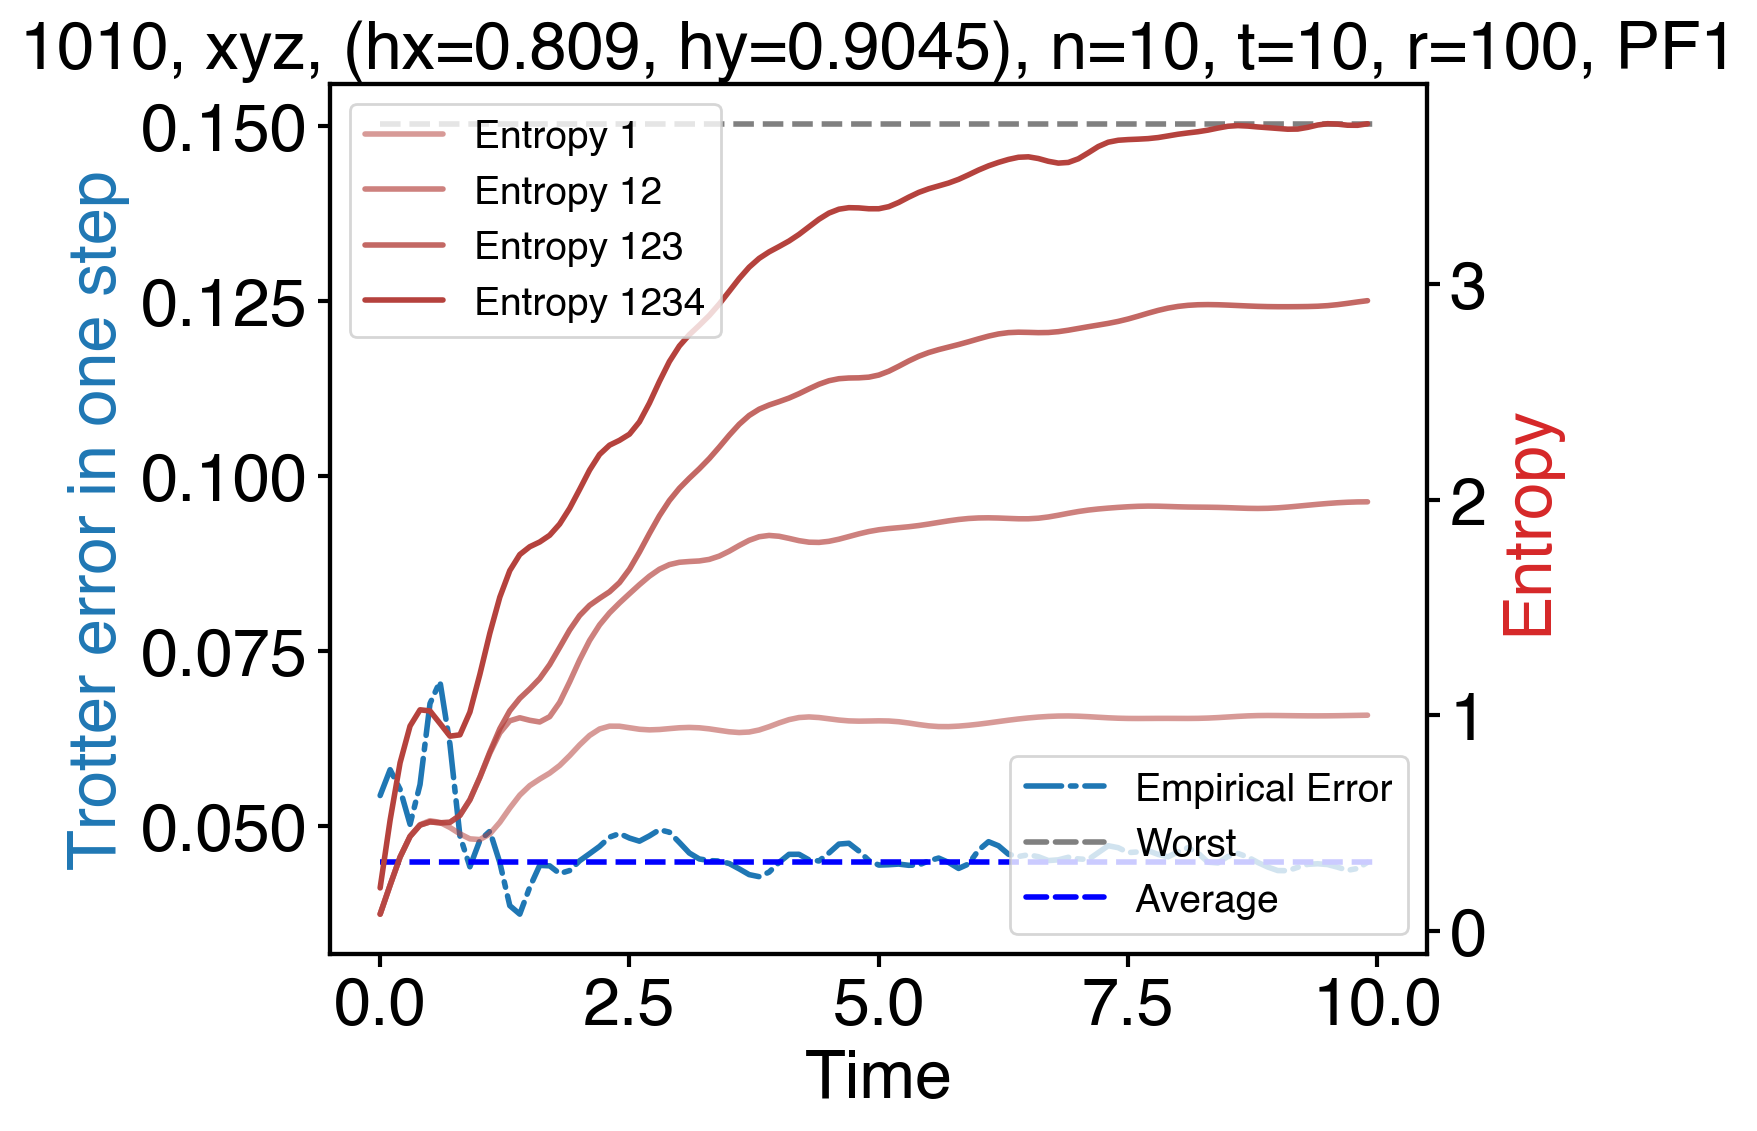

In [5]:
n, t = 10, 5*2
r = 100
H_typical = 'typical'
psi0 = '1010'
grouping = 'xyz'  # parity, xyz
pf_order = 1  # product formula order: 1, 2, 4

if psi0 == '0000':
    init_state = Statevector.from_label('0'*n)
elif psi0 == '1010':
    init_state = Statevector.from_label('10'* (n//2)+'1'*(n%2))
# elif psi0 == 'rand':
else:
    raise ValueError('invalid initial state')

if H_typical=='typical':
    # QIMF = Nearest_Neighbour_1d(n, hx=0.8001, hy=0.8908, Jx=1, pbc=False)
    QIMF = Nearest_Neighbour_1d(n, hx=0.8090, hy=0.9045,Jx=1, pbc=False)
elif H_typical=='atypical':
    # QIMF = Nearest_Neighbour_1d(n, hx=0.8, hy=0.9, Jx=1, pbc=False)
    QIMF = Nearest_Neighbour_1d(n, hx=0.0, hy=0.9045, Jx=1, pbc=False)
else:
    raise ValueError('invalid typical')

if grouping == 'parity':
    H_list = QIMF.ham_par
    # H_list = [h for h in QIMF.ham_par]
elif grouping == 'xyz':
    H_list = QIMF.ham_xyz
else:
    raise ValueError('invalid grouping')
print('Hamiltonian list: \n', H_list)

if pf_order <= 2:
    appro_U, exact_U = pf(H_list, t/r, 1, order=pf_order, return_exact=True, use_jax=False)
else: 
    appro_U = pf_high(H_list, t/r, 1, order=pf_order)
    exact_U = expH(sum(H_list), t/r)

emp_err_list, entropy_list, purity_list = [], [], []

current_state = init_state.data  

for d in range(r):
    print('+', end='')
    # U_exact = expH(QIMF.ham, t)
    current_state = current_state/np.linalg.norm(current_state)
    ideal_state = exact_U @ current_state   
    current_state = appro_U @ current_state
    #finl_state = U_exact @ init_state
    rdm1 = partial_trace(DensityMatrix(Statevector(current_state)), [0])
    rdm2 = partial_trace(DensityMatrix(Statevector(current_state)), [0,1])
    rdm3 = partial_trace(DensityMatrix(Statevector(current_state)), [0,1,2])
    rdm4 = partial_trace(DensityMatrix(Statevector(current_state)), [0,1,2,4])
    ## qiskit partial trace is not a valid density matrix within the tolerance for entropy
    # purity_list.append(rdm.purity())
    # print(rdm1)
    if rdm1.is_valid() and rdm2.is_valid() and rdm3.is_valid() and rdm4.is_valid():
        pass
    else:
        print('not valid density matrix')
        print(d, rdm1.is_valid(), np.trace(rdm1), rdm1.atol, rdm1.rtol)
        print(rdm1.is_valid(), rdm2.is_valid(), rdm3.is_valid(), rdm4.is_valid())
        rdm1, rdm2, rdm3, rdm4 = DensityMatrix(rdm1.data/np.trace(rdm1)), DensityMatrix(rdm2.data/np.trace(rdm2)), DensityMatrix(rdm3.data/np.trace(rdm3)), DensityMatrix(rdm3.data/np.trace(rdm4))
    # print(isinstance(rdm1, (Statevector, DensityMatrix)))
    temp_entropy = [entropy(rdm1), entropy(rdm2), entropy(rdm3), entropy(rdm4)]
    print(temp_entropy)
    entropy_list.append(temp_entropy)
    emp_err_list.append(np.linalg.norm(current_state - ideal_state))

if pf_order <= 2:
    worst_bound = tight_bound(H_list, pf_order, t/r, 1)
    averg_bound = tight_bound(H_list, pf_order, t/r, 1, type='fro')
t_list = np.array(range(r))*t/r 
entropy_list = np.array(entropy_list)


plt.rc('legend', fontsize=MEDIUM_SIZE-4) 

fig, ax = plt.subplots()
ax.plot(t_list, emp_err_list, '-.', label=f'Empirical Error', c="tab:blue")
if pf_order <= 2:
    ax.hlines(worst_bound, 0, t, colors='grey', linestyles='dashed', label='Worst')
    ax.hlines(averg_bound, 0, t, colors='blue', linestyles='dashed', label='Average')
    
ax.set_xlabel('Time')
ax.set_ylabel('Trotter error in one step', color='tab:blue')
ax.set_title(f'{psi0}, {grouping}, (hx={QIMF.hx}, hy={QIMF.hy}), n={n}, t={t}, r={r}, PF{pf_order}')
# twin y axis for empirical error
ax2 = ax.twinx()
ax2.set_ylabel('Entropy', color='tab:red')
ax2.plot(t_list, entropy_list[:, 0], '-', label=f'Entropy 1', c="#b5423d88")
ax2.plot(t_list, entropy_list[:, 1], '-', label=f'Entropy 12', c="#b5423dAA")
ax2.plot(t_list, entropy_list[:, 2], '-', label=f'Entropy 123', c="#b5423dCC")
ax2.plot(t_list, entropy_list[:, 3], '-', label=f'Entropy 1234', c="#b5423dFF")
ax.legend(loc='lower right'); 
ax2.legend()

# fig.savefig(f'{fig_dir}/entropy_onestep_error_n={n}_t={t}_r={r}_hx={QIMF.hx}_hy={QIMF.hy}_{psi0}_jax_{H_typical}_{grouping}_PF{pf_order}.pdf', bbox_inches='tight')